In [98]:
from newscatcherapi import NewsCatcherApiClient
newscatcherapi = NewsCatcherApiClient(x_api_key = 'ItRKYxXNxrJUsUcybFkXA9CRUkSFl-OIUtfZXZG4rKU')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import snscrape.modules.twitter as sntwitter
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [474]:
stockname_t = 'microsoft'
stockname_p = 'msft'
end_date = '2022-11-13'
start_date = '2022-10-31'

In [475]:
all_articles = newscatcherapi.get_search(q=stockname_t, lang='en', from_= start_date, to_ = end_date)

In [477]:
df = pd.DataFrame(all_articles['articles'])
df.shape

(50, 19)

In [478]:
df = df.drop(['author','published_date_precision','link','clean_url','excerpt','summary','rights','rank','topic','country','language','authors','media','is_opinion','twitter_account','_score','_id'],axis=1)

In [479]:
df.rename(columns={'published_date':'Date'},inplace=True)
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [480]:
df.head()

,title,Date
0,Microsoft Create is here to make the company's...,2022-11-08
1,Headed to São Paulo? Don't miss these unforget...,2022-11-05
2,Microsoft launches early preview of Create web...,2022-11-08
3,Microsoft: Top Recession Value (NASDAQ:MSFT),2022-11-07
4,"Crown Princess Amalia under fire: ""that tongue!""",2022-11-09


In [482]:
query = stockname_t+' min_faves:100 until:'+end_date+' since:'+start_date+ 'lang:en'
tweets = []

for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    tweets.append([tweet.date.date(), tweet.content])
    
df_tweet = pd.DataFrame(tweets, columns=['Date', 'Tweets'])

df_tweet = df_tweet.drop_duplicates(subset=['Date'])

In [483]:
df_tweet.head()

,Date,Tweets
0,2022-11-12,"Sorry Tim, many of us don’t see Phil as Jesus ..."
52,2022-11-11,@DMC_Ryan @RCardosoEU They're working hard to ...
125,2022-11-10,2 years of Xbox Series X / S today. Even 2 yea...
205,2022-11-09,"so far most of my success as a lawyer*, if ind..."
275,2022-11-08,"Hay pocas cosas que odio en mi vida, una de el..."


In [484]:
df_tweet.shape

(13, 2)

In [485]:
merge = df_tweet.merge(df, how='outer')

df1 = pd.DataFrame.from_dict(merge)

In [486]:
news_tweet = []
for row in range(0, len(df1.index)):
    news_tweet.append(' '.join(str(x) for x in df1.iloc[row, 1:2]))

In [487]:
df1['Combined'] = news_tweet

In [488]:
df_news_tweets = df1.drop(['Tweets','title'],axis=1)

In [490]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [491]:
df_news_tweets['Subjectivity'] = df_news_tweets['Combined'].apply(getSubjectivity)
df_news_tweets['Polarity'] = df_news_tweets['Combined'].apply(getPolarity)

In [492]:
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

In [493]:
compound, neg, pos, neu = [], [], [], []
SIA = 0

for i in range(0, len(df_news_tweets['Combined'])):
    SIA = getSIA(df_news_tweets['Combined'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])
    
df_news_tweets['Positive'] = pos
df_news_tweets['Negative'] = neg
df_news_tweets['Neutral'] = neu
df_news_tweets['Compound'] = compound

In [494]:
df_news_tweets = df_news_tweets.drop(['Combined','Subjectivity', 'Polarity'],axis=1)

In [495]:
import yfinance as yf

In [496]:
df_price = pd.DataFrame()

df_price = yf.download(stockname_p, start=start_date, end=end_date)
df_price = df_price.reset_index()
df_price = df_price.drop(['Open','High','Low','Adj Close','Volume'],axis=1)
df_price['Date'] = pd.to_datetime(df_price['Date']).dt.date

[*********************100%***********************]  1 of 1 completed


In [498]:
merge1 = df_price.merge(df_news_tweets, on='Date',how='outer')

In [499]:
df_news_price_tweets = pd.DataFrame.from_dict(merge1)
df_news_price_tweets.shape

(53, 6)

In [500]:
df_news_price_tweets.head()

,Date,Close,Positive,Negative,Neutral,Compound
0,2022-10-31,232.130005,0.000,0.000,1.000,0.0000
1,2022-11-01,228.169998,0.077,0.115,0.809,-0.2263
2,2022-11-02,220.100006,0.000,0.000,1.000,0.0000
3,2022-11-02,220.100006,0.000,0.000,1.000,0.0000
4,2022-11-03,214.250000,0.000,0.000,1.000,0.0000


In [501]:
df_news_price_tweets = df_news_price_tweets.dropna()

In [502]:
df_news_price_tweets.shape

(48, 6)

In [506]:
num_shape = 20

In [507]:
train = df_news_price_tweets.iloc[:num_shape, 1:2].values
test = df_news_price_tweets.iloc[num_shape:, 1:2].values

In [508]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [509]:
import numpy as np

In [510]:
X_train = []

#Price on next day
y_train = []

window = 3

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [511]:
# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 3, 50)             10400     
                                                                 
 dropout_72 (Dropout)        (None, 3, 50)             0         
                                                                 
 lstm_37 (LSTM)              (None, 3, 50)             20200     
                                                                 
 dropout_73 (Dropout)        (None, 3, 50)             0         
                                                                 
 lstm_38 (LSTM)              (None, 3, 50)             20200     
                                                                 
 dropout_74 (Dropout)        (None, 3, 50)             0         
                                                                 
 lstm_39 (LSTM)              (None, 50)              

In [512]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 3);

Epoch 1/100
6/6 [==============================] - 9s 22ms/step - loss: 0.4455
Epoch 2/100
6/6 [==============================] - 0s 24ms/step - loss: 0.3868
Epoch 3/100
6/6 [==============================] - 0s 20ms/step - loss: 0.3005
Epoch 4/100
6/6 [==============================] - 0s 20ms/step - loss: 0.2000
Epoch 5/100
6/6 [==============================] - 0s 17ms/step - loss: 0.1261
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0898
Epoch 7/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0785
Epoch 8/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0842
Epoch 9/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0839
Epoch 10/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0925
Epoch 11/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0911
Epoch 12/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0903
Epoch 13/100
6/6 [==============================]

In [513]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
   
X_test = np.stack(X_test)

In [514]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

In [515]:
predict

array([[227.11633],
       [227.11633],
       [227.11633],
       [227.11633],
       [227.11633],
       [227.11633],
       [227.11633],
       [225.64833],
       [224.50255],
       [223.86499],
       [223.86499],
       [223.86499],
       [223.86499],
       [223.86499],
       [223.86499],
       [223.86499],
       [223.86499],
       [223.86499],
       [223.86499],
       [230.00665],
       [240.00607],
       [243.67224],
       [243.67224],
       [243.67224],
       [243.67224],
       [243.67224],
       [243.67224],
       [243.67224]], dtype=float32)

In [516]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 20.982636224678053
MAE: 2.2404512677873885
RMSE: 4.580680759961128


In [517]:
pred_ = predict[-1].copy()
prediction_full = []
window = 3
df_copy = df_news_price_tweets.iloc[:, 1:2][1:].values

for j in range(10):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [518]:
df_date_LSTM = df_news_price_tweets[['Date']]

for h in range(10):
    df_date_add = pd.to_datetime(df_date_LSTM['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date_LSTM = df_date_LSTM.append(df_date_add)
df_date_LSTM = df_date_LSTM.reset_index(drop=True)
df_date_LSTM=df_date_LSTM.iloc[-10:]
df_date_LSTM['Prediction']=prediction_full

In [519]:
df_date_LSTM

,Date,Prediction
48,2022-11-12,247.218094
49,2022-11-13,247.218094
50,2022-11-14,245.750198
51,2022-11-15,227.559616
52,2022-11-16,225.678116
53,2022-11-17,223.887680
54,2022-11-18,223.471939
55,2022-11-19,231.256195
56,2022-11-20,244.542953
57,2022-11-21,225.240692


In [520]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

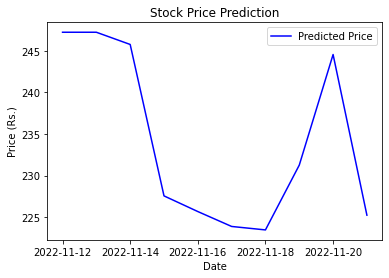

In [521]:
plt.figure()
df_date_LSTM.plot(x='Date',y='Prediction', color = 'blue', label = 'Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (Rs.)')
plt.legend()
plt.show()

In [522]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_36 (GRU)                (None, 3, 50)             7950      
                                                                 
 dropout_76 (Dropout)        (None, 3, 50)             0         
                                                                 
 gru_37 (GRU)                (None, 3, 50)             15300     
                                                                 
 dropout_77 (Dropout)        (None, 3, 50)             0         
                                                                 
 gru_38 (GRU)                (None, 3, 50)             15300     
                                                                 
 dropout_78 (Dropout)        (None, 3, 50)             0         
                                                                 
 gru_39 (GRU)                (None, 50)              

In [523]:
modelGRU.compile(optimizer='adam', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=100, batch_size=3)

Epoch 1/100
6/6 [==============================] - 8s 18ms/step - loss: 0.3368
Epoch 2/100
6/6 [==============================] - 0s 30ms/step - loss: 0.1360
Epoch 3/100
6/6 [==============================] - 0s 24ms/step - loss: 0.1184
Epoch 4/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1092
Epoch 5/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0836
Epoch 6/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0869
Epoch 7/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0984
Epoch 8/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0795
Epoch 9/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0768
Epoch 10/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0729
Epoch 11/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0821
Epoch 12/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0874
Epoch 13/100
6/6 [==============================]

In [524]:
predictGRU = modelGRU.predict(X_test)
predictGRU = sc.inverse_transform(predictGRU)

In [525]:
diff = predictGRU - test
print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 15.877101374016743
MAE: 2.306928907121931
RMSE: 3.9846080577663776


In [526]:
prediction_full = []
window = 3
df_copy = df_news_price_tweets.iloc[:, 1:2][1:].values

for j in range(10):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [527]:
df_date_GRU = df_news_price_tweets[['Date']]

for h in range(10):
    df_date_add = pd.to_datetime(df_date_GRU['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date_GRU = df_date_GRU.append(df_date_add)
df_date_GRU = df_date_GRU.reset_index(drop=True)
df_date_GRU=df_date_GRU.iloc[-10:]
df_date_GRU['Prediction']=prediction_full

In [528]:
df_date_GRU

,Date,Prediction
48,2022-11-12,248.709976
49,2022-11-13,248.709976
50,2022-11-14,229.569733
51,2022-11-15,224.224182
52,2022-11-16,224.314514
53,2022-11-17,224.314514
54,2022-11-18,246.253174
55,2022-11-19,249.801361
56,2022-11-20,226.039978
57,2022-11-21,223.824448


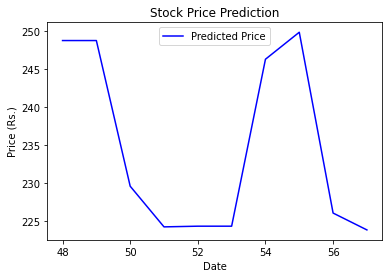

In [529]:
plt.figure()
df_date_GRU.plot(x='Date',y='Prediction', color = 'blue', label = 'Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (Rs.)')
plt.legend()
plt.show()